# Overview
Several plots are created.

## Plots from the same dataset:

- Number of new Corona cases overtime. (CA, NY)
- Number of cancelled flights overtime. (CA, NY)
- Number of vaccinated people overtime. (CA, NY)
- Number of performed flights, delayed flights with and without weather delay over time. (Total)
- Number of employees overtime. (Total)

## Correlations
- Scatter plot of Cancelled Flight vs. Performed Flight

In [10]:
import psycopg2
import pandas as pd
import numpy as np

In [11]:
from bokeh.plotting import figure, show, save
from bokeh.layouts import row, column, gridplot
from bokeh.models import DatetimeTickFormatter, MonthsTicker
from bokeh.models import Button, CustomJS, Legend
from bokeh.embed import file_html
from bokeh.io import show, output_file, export_png
from bokeh.models import Div
from bokeh.resources import CDN

In [12]:
# create Connection with PostgreSQL Database
conn = psycopg2.connect(user='Yannu', password='DB123', host='localhost', database='DB_UniBasel')
cursor = conn.cursor()

In [13]:
def coronaCases(state):
    print("num new cases")
    #log
    print(state)
    
    #get data
    query = """SELECT DATE_TRUNC('week', d.date) "Week", cast(SUM(d.new_case) as decimal)/ s.citizens "Number of Corona Cases"
                FROM CoronaData d, State s
                WHERE s.state = d.state 
                        AND s.state = '""" + state + """'
                GROUP BY "Week", s.state
                ORDER BY "Week" ASC """
    cursor.execute(query)
    
    #save results
    df = pd.DataFrame(cursor.fetchall())
    df.columns = ['Date', 'New Corona Cases']
    
    return df

In [14]:
def coronaCasesMonthly(state):
    print("num new cases")
    #log
    print(state)
    
    #get data
    query = """SELECT TO_CHAR(DATE_TRUNC('month', d.date), 'YYYY-MM') "Month", cast(SUM(d.new_case) as float)/ s.citizens "Number of Corona Cases"
                FROM CoronaData d, State s
                WHERE s.state = d.state 
                        AND s.state = '""" + state + """'
                GROUP BY "Month", s.state
                ORDER BY "Month" ASC """
    cursor.execute(query)
    
    #save results
    df = pd.DataFrame(cursor.fetchall())
    df.columns = ['Date', 'New Corona Cases']
    
    return df

In [15]:
def cancelledFlights(state):
        print("cancelledFlights")
        #log
        print(state)
        
        #get data
        query = """SELECT DATE_TRUNC('month', f.flightdate) "Month", COUNT(*) "Number of cancelled Flights"
                FROM Flight f, State s, Airport a, City c
                WHERE (f.OriginAirportID = a.AirportID
                        AND a.CityID = c.CityID 
                        AND c.State = s.state
                        AND s.state = '""" + state + """'
                        AND f.cancelled = 1)
                GROUP BY "Month"
                ORDER BY "Month" Asc """
        cursor.execute(query)
        
        #save results
        df = pd.DataFrame(cursor.fetchall())
        df.columns = ['Date', 'Cancelled Flights']
        
        return df

In [16]:
def cancelledFlightsMonthly(state):
        print("cancelledFlights")
        #log
        print(state)
        
        #get data
        query = """SELECT TO_CHAR(DATE_TRUNC('month', f.flightdate), 'YYYY-MM') "Month", COUNT(*) "Number of cancelled Flights"
                FROM Flight f, State s, Airport a, City c
                WHERE (f.OriginAirportID = a.AirportID
                        AND a.CityID = c.CityID 
                        AND c.State = s.state
                        AND s.state = '""" + state + """'
                        AND f.cancelled = 1)
                GROUP BY "Month"
                ORDER BY "Month" Asc """
        cursor.execute(query)
        
        #save results
        df = pd.DataFrame(cursor.fetchall())
        df.columns = ['Date', 'Cancelled Flights']
        
        return df

In [17]:
def vaccination(state):
    print("Vaccination")
    #log
    if state == 'CA':
            print("california")
    if state == 'NY':
            print("new york")
    
    #get data
    query = """SELECT DATE_TRUNC('day', cv.date), SUM(cv.series_complete_yes)/SUM(cv.census) "Number of Covid Vaxxed",
                                SUM(cv.booster_doses)/SUM(cv.census) "Number of Booster",
                                Sum(cv.second_booster)/SUM(cv.census) "Number of Second Booster"
                FROM CoronaVax cv, State c
                WHERE (cv.Location = c.State AND cv.Location = '"""+ state + """')
                GROUP BY cv.date, c.State
                ORDER BY cv.date ASC """
    cursor.execute(query)
    
    #save results
    df = pd.DataFrame(cursor.fetchall())
    df.columns = ['Date', 'Number of Covid Vaxxed', 'Number of Booster', 'Number of Second Booster']
    
    return df
    

In [18]:
def delays(weather='with Weather Delay'):
    print("Delayed Flights")
    
    withouthWeather = "AND df.weatherdelay = 0" if weather == 'without Weather Delay' else ""
    
    #get data
    query = """ SELECT DATE_TRUNC('month', f.flightdate) "Month", COUNT(*) "Number of Delayed Flights"
                FROM delayed_Flight df, Flight f
                WHERE (df.flight_id = f.flight_id
                        """ + withouthWeather + """)
                GROUP BY "Month"
                ORDER BY "Month" ASC"""
                
    cursor.execute(query)
    
    #save results
    df = pd.DataFrame(cursor.fetchall())
    df.columns = ['Date', 'Number of Delayed Flights']
    
    return df
    

In [19]:
def preformedFlights():
    print("Performed Flights")
    
    #get data
    query = """ SELECT DATE_TRUNC('month', f.flightdate) "Month", COUNT(*) "Number of performed Flights"
                FROM Flight f
                WHERE f.cancelled = 0
                GROUP BY "Month"
                ORDER BY "Month" ASC"""
                
    cursor.execute(query)
    
    #save results
    df = pd.DataFrame(cursor.fetchall())
    df.columns = ['Date', 'Number of Performed Flights']
    
    return df
    

In [20]:
def employee():
    print("Performed Flights")
    
    #get data
    query = """ SELECT DATE_TRUNC('month', date) "Month", fulltime, parttime, grand_total
                FROM Employment
                WHERE date >= '2017-07-01' AND date <= '2022-07-01'
                ORDER BY date ASC"""
                
    cursor.execute(query)
    
    #save results
    df = pd.DataFrame(cursor.fetchall())
    df.columns = ['Date', 'Fulltime', 'Parttime', 'Grand Total']
    
    return df


In [21]:
def createFigure(x, y, color="black", legend_Label="", title="", x_axis_label="", y_axis_label="", x_axis_type="", forVax=False, scatter=False):
    # check if color, x and y are lists
    if not isinstance(x, list):
        x = [x]
    if not isinstance(y, list):
        y = [y]
    if not isinstance(color, list):
        color = [color]
    if not isinstance(legend_Label, list):
        legend_Label = [legend_Label]
    
    if x_axis_type == "":
        fig = figure(title=title,
                    x_axis_label=x_axis_label,
                    y_axis_label=y_axis_label,
                    toolbar_location='left',
                    plot_width=900,
                    plot_height=600,
                    )
    else:
        fig = figure(title=title,
                    x_axis_label=x_axis_label,
                    y_axis_label=y_axis_label,
                    x_axis_type=x_axis_type,
                    toolbar_location='left',
                    plot_width=900,
                    plot_height=600,
                    )
    
    line = []
    
    # add data to figure
    for i in range(len(x)):
        if forVax:
            if scatter:
                line.append(fig.scatter(x[i], y[i], line_width=2, color=color[i]))
            else:
                line.append(fig.line(x[i], y[i], line_width=2, color=color[i]))
        else:
            if scatter:
                line.append(fig.scatter(x[i], y[i], legend_label=legend_Label[i], line_width=2, color=color[i]))
            else:
                line.append(fig.line(x[i], y[i], legend_label=legend_Label[i], line_width=2, color=color[i]))
                
            
        
    # set start values
    fig.y_range.start = 0
    fig.x_range.start = min(x[:][0])
    
    fig.xaxis.ticker = MonthsTicker(months=[0, 6])
    fig.title.align = 'center'
    return fig, line

In [22]:
# new Corona cases over time
dfcoronaCA = coronaCases('CA')
dfcoronaNY = coronaCases('NY')

coronaX = [dfcoronaCA['Date'], dfcoronaNY['Date']]
coronaY = [dfcoronaCA['New Corona Cases'], dfcoronaNY['New Corona Cases']]
figCorona, lineCorona = createFigure(x=coronaX, y=coronaY, 
                                     color=["#0575a8", "#eb075a"], 
                                     legend_Label=["California", "New York"], 
                                     title="Number of New Corona Cases over Time", 
                                     x_axis_label='Date', 
                                     y_axis_label='Relative Number of New Corona Cases', 
                                     x_axis_type="datetime")
figCorona.legend.click_policy="hide"
show(figCorona)
save(figCorona, filename="html\\NewCoronaCases.html")




num new cases
CA
num new cases
NY


C:\Users\yanni\anaconda3\lib\site-packages\bokeh\io\saving.py:127: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
C:\Users\yanni\anaconda3\lib\site-packages\bokeh\io\saving.py:140: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'C:\\Users\\yanni\\Desktop\\Database\\Projekt\\group-5\\WorkingStation\\WorkingStationP2\\html\\NewCoronaCases.html'

In [23]:
# number of cancelled flights over time
dfcancelFCA = cancelledFlights('CA')
dfcancelFNY = cancelledFlights('NY')

cancelledFlightsX = [dfcancelFCA['Date'], dfcancelFNY['Date']]
cancelledFlightsY = [dfcancelFCA['Cancelled Flights']/max(dfcancelFCA['Cancelled Flights']), dfcancelFNY['Cancelled Flights']/max(dfcancelFNY['Cancelled Flights'])]
figCancelledFlights, lineCancelledFlight = createFigure(x=cancelledFlightsX, 
                                                        y=cancelledFlightsY, 
                                                        color=["#0575a8", "#eb075a"], 
                                                        legend_Label=["California", "New York"], 
                                                        title="Number of Cancelled Flights over Time", x_axis_label='Date', 
                                                        y_axis_label='Relative Number of Cancelled Flights', 
                                                        x_axis_type="datetime")
figCancelledFlights.legend.click_policy="hide"
show(figCancelledFlights)
save(figCancelledFlights, filename="html\\CancelledFlights.html")

cancelledFlights
CA
cancelledFlights
NY


'C:\\Users\\yanni\\Desktop\\Database\\Projekt\\group-5\\WorkingStation\\WorkingStationP2\\html\\CancelledFlights.html'

In [24]:
# number of vaccinated people over time
dfvaxCA = vaccination('CA')
dfvaxNY = vaccination('NY')

vaxX = [dfvaxCA['Date'], dfvaxCA['Date'], dfvaxCA['Date'],
        dfvaxNY['Date'], dfvaxNY['Date'],dfvaxNY['Date']]
vaxY = [dfvaxCA['Number of Covid Vaxxed'], dfvaxCA['Number of Booster'], dfvaxCA['Number of Second Booster'],
        dfvaxNY['Number of Covid Vaxxed'], dfvaxNY['Number of Booster'], dfvaxNY['Number of Second Booster']]
figVax, lineVax = createFigure(x=vaxX,
                               y=vaxY, 
                               color=["#0575a8", "#07ebcc", "#07eb71", "#eb07c9", "#eb075a", "#eba307"],  
                               title="Number of Vaccinations", 
                               x_axis_label='Date', 
                               y_axis_label='Relative Number of Vaccinated People', 
                               x_axis_type="datetime", 
                               forVax=True)
legend1 = Legend(items=[("Covid Vaxxed" , [lineVax[0]]), ("Booster", [lineVax[1]]), ("Second Booster", [lineVax[2]])], title="California", location=(5, 400))
legend2 = Legend(items=[("Covid Vaxxed" , [lineVax[3]]), ("Booster", [lineVax[4]]), ("Second Booster", [lineVax[5]])], title="New York", location=(-150, 280))
figVax.add_layout(legend1, 'right')
figVax.add_layout(legend2, 'right')
figVax.legend.click_policy="hide"
show(figVax)
save(figVax, filename="html\\Vaccination.html")

Vaccination
california
Vaccination
new york


'C:\\Users\\yanni\\Desktop\\Database\\Projekt\\group-5\\WorkingStation\\WorkingStationP2\\html\\Vaccination.html'

In [25]:
# number of performed flights incl. delays over time
dfPerformed = preformedFlights()
# number of delayed flights over time
dfDelayWith = delays()
# number of delayed flights without weather delay over time
dfDelayWithout = delays('without Weather Delay')

perfX = [dfPerformed['Date'],
         dfDelayWith['Date'], dfDelayWithout['Date']]
perfY = [dfPerformed['Number of Performed Flights'],
         dfDelayWith['Number of Delayed Flights'], dfDelayWithout['Number of Delayed Flights']]
figPerf, linePerf = createFigure(x=perfX,
                                y=perfY,
                                color=["#0575a8", "#eb07c9", "#eb075a"],
                                title="Number of Performed Flights incl. Delays",
                                x_axis_label='Date',
                                y_axis_label='Number of Flights',
                                x_axis_type="datetime",
                                forVax=True)
legend1 = Legend(items=[("performed" , [linePerf[0]])], title="Performed flights", location=(5, 400))
legend2 = Legend(items=[("delayed" , [linePerf[1]]), ("delayed without weather delay", [linePerf[2]])], title="Delayed flights", location=(-130, 300))
figPerf.add_layout(legend1, 'right')
figPerf.add_layout(legend2, 'right')
figPerf.legend.click_policy="hide"
show(figPerf)
save(figPerf, filename="html\\Performed Flights.html")

Performed Flights
Delayed Flights
Delayed Flights


'C:\\Users\\yanni\\Desktop\\Database\\Projekt\\group-5\\WorkingStation\\WorkingStationP2\\html\\Performed Flights.html'

In [26]:
# number of employees over time
dfEmployee = employee()

empX = [dfEmployee['Date'], dfEmployee['Date'], dfEmployee['Date']]
empY = [dfEmployee['Fulltime'], dfEmployee['Parttime'], dfEmployee['Grand Total']]
figEmp, lineEmp = createFigure(x=empX,
                               y=empY,
                               color=["#0575a8", "#07eb71", "#eb075a"],
                               title="Total Number of Employees over Time",
                               x_axis_label='Date',
                               y_axis_label='Number of Employees',
                               x_axis_type="datetime",
                               forVax=True)
legend1 = Legend(items=[("Fulltime" , [lineEmp[0]]), ("Parttime", [lineEmp[1]]), ("Grand Total", [lineEmp[2]])], location=(5, 400))
figEmp.add_layout(legend1, 'right')
figEmp.legend.click_policy="hide"

show(figEmp)
save(figEmp, filename="html\\Employee.html")

Performed Flights


'C:\\Users\\yanni\\Desktop\\Database\\Projekt\\group-5\\WorkingStation\\WorkingStationP2\\html\\Employee.html'

In [27]:
dfcoronaCA = coronaCasesMonthly('CA')
dfcoronaNY = coronaCasesMonthly('NY')

dfcancelFCA = cancelledFlightsMonthly('CA')
dfcancelFNY = cancelledFlightsMonthly('NY')

dfcanCorCA = pd.merge(dfcancelFCA, dfcoronaCA, on='Date')
dfcanCorNY = pd.merge(dfcancelFNY, dfcoronaNY, on='Date')

cancorX = [dfcanCorCA['Cancelled Flights'], dfcanCorNY['Cancelled Flights']]
cancorY = [dfcanCorCA['New Corona Cases'], dfcanCorNY['New Corona Cases']]

num new cases
CA
num new cases
NY
cancelledFlights
CA
cancelledFlights
NY


Correlation coefficient: 0.08743583002170909
p-value: 0.6399891063755834


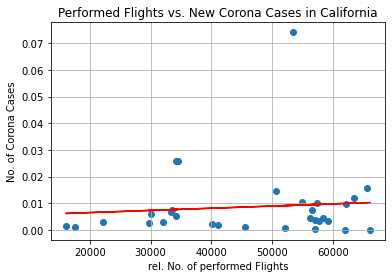

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

query =  """SELECT to_char(DATE_TRUNC('month', f.flightdate), 'YYYY-MM') "Month", COUNT(*) "Number of performed Flights"
                FROM Flight f, State s, Airport a, City c
                WHERE (f.OriginAirportID = a.AirportID
                        AND a.CityID = c.CityID 
                        AND c.State = s.state
                        AND s.state = 'CA'
                        AND f.cancelled = 0)
                GROUP BY "Month"
                ORDER BY "Month" Asc """
                
cursor.execute(query)
    
#save results
df = pd.DataFrame(cursor.fetchall())
df.columns = ['Date', 'CA']
dfcanCorCA = pd.merge(df, dfcoronaCA, on='Date')

x = dfcanCorCA['CA']
y = dfcanCorCA['New Corona Cases']

# Calculate the Pearson correlation coefficient and p-value
corr_coef, p_value = pearsonr(x, y)
print("Correlation coefficient:", corr_coef)
print("p-value:", p_value)

plt.scatter(x,y)
slope, intercept = np.polyfit(x, y, 1)
plt.plot(x, slope * x + intercept, "r")
plt.xlabel("rel. No. of performed Flights")
plt.ylabel("No. of Corona Cases")
plt.grid(True)
plt.title("Performed Flights vs. New Corona Cases in California")
plt.show()

Correlation coefficient: 0.19759631523466736
p-value: 0.2866456751257925


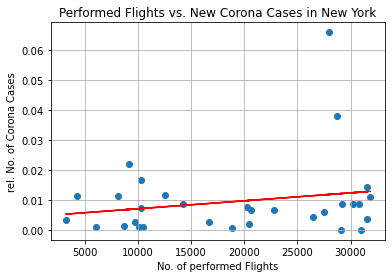

In [30]:
query =  """SELECT to_char(DATE_TRUNC('month', f.flightdate), 'YYYY-MM') "Month", COUNT(*) "Number of performed Flights"
                FROM Flight f, State s, Airport a, City c
                WHERE (f.OriginAirportID = a.AirportID
                        AND a.CityID = c.CityID 
                        AND c.State = s.state
                        AND s.state = 'NY'
                        AND f.cancelled = 0)
                GROUP BY "Month"
                ORDER BY "Month" Asc """
                
cursor.execute(query)
df = pd.DataFrame(cursor.fetchall())
df.columns = ['Date', 'NY']
dfcanCorCA = pd.merge(df, dfcoronaNY, on='Date')
x = dfcanCorCA['NY']
y = dfcanCorCA['New Corona Cases']

# Calculate the Pearson correlation coefficient and p-value
corr_coef, p_value = pearsonr(x, y)
print("Correlation coefficient:", corr_coef)
print("p-value:", p_value)

plt.scatter(x,y)
slope, intercept = np.polyfit(x, y, 1)
plt.plot(x, slope * x + intercept, "r")
plt.xlabel("No. of performed Flights")
plt.ylabel("rel. No. of Corona Cases")
plt.grid(True)
plt.title("Performed Flights vs. New Corona Cases in New York")
plt.show()

Correlation coefficient: 0.0791183947781513
p-value: 0.36717900912693835


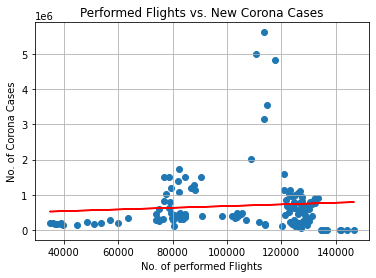

In [31]:
query =  """Select Date_trunc('week',f.flightdate) "week", count(*)
from flight f
where cancelled = 0
group by "week" """
cursor.execute(query)
dfflight = pd.DataFrame(cursor.fetchall())
dfflight.columns = ['Date', 'N.Flights']

query =  """Select DATE_TRUNC('week',Coronadata.date) "week", SUM(Coronadata.new_case) "Number of Corona Cases"
From CoronaData
Group BY  "week" """
cursor.execute(query)
dfcorona = pd.DataFrame(cursor.fetchall())
dfcorona.columns = ['Date', 'N.Corona']

dfcanCor = pd.merge(dfflight, dfcorona, on='Date')
x = dfcanCor['N.Flights']
y = dfcanCor['N.Corona']

corr_coef, p_value = pearsonr(x, y)
print("Correlation coefficient:", corr_coef)
print("p-value:", p_value)

plt.scatter(x,y)
slope, intercept = np.polyfit(x, y, 1)
plt.plot(x, slope * x + intercept, "r")
plt.xlabel("No. of performed Flights")
plt.ylabel("No. of Corona Cases")
plt.grid(True)
plt.title("Performed Flights vs. New Corona Cases")
plt.show()

Correlation coefficient Vaccs: 0.011128284047842336
p-value: 0.9133973949291805
Correlation coefficient B1: -0.03966239264362367
p-value: 0.7576046098362336
Correlation coefficient B2: -0.2913031282944447
p-value: 0.02054032903302516


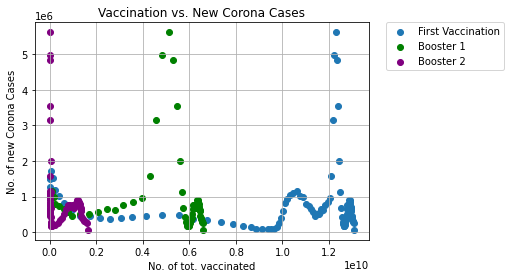

In [32]:
query =  """Select DATE_TRUNC('week', cv.date) "week", SUM(cv.series_complete_yes) "Number of Covid Vaxxed", SUM(cv.booster_doses) "Number of Booster", Sum(cv.second_booster) "Number of second Booster"
From CoronaVax cv
Group BY "week" """
cursor.execute(query)
dfvax = pd.DataFrame(cursor.fetchall())
dfvax.columns = ['Date', 'N.Vax', 'N.B1', 'N.B2']

dfcanCor = pd.merge(dfvax[['Date','N.Vax']], dfcorona, on='Date')
x = dfcanCor['N.Vax']
y = dfcanCor['N.Corona']

dfcanCor = pd.merge(dfvax[['Date','N.B1']].dropna(), dfcorona, on='Date')
x2 = dfcanCor['N.B1']
y2 = dfcanCor['N.Corona']

dfcanCor = pd.merge(dfvax[['Date','N.B2']].dropna(), dfcorona, on='Date')
x3 = dfcanCor['N.B2']
y3 = dfcanCor['N.Corona']

corr_coef, p_value = pearsonr(x, y)
print("Correlation coefficient Vaccs:", corr_coef)
print("p-value:", p_value)

corr_coef, p_value = pearsonr(x2, y2)
print("Correlation coefficient B1:", corr_coef)
print("p-value:", p_value)

corr_coef, p_value = pearsonr(x3, y3)
print("Correlation coefficient B2:", corr_coef)
print("p-value:", p_value)

plt.scatter(x,y, label = 'First Vaccination')
plt.scatter(x2,y2, color='green', label = 'Booster 1')
plt.scatter(x3,y3, color = 'purple', label = 'Booster 2')

slope, intercept = np.polyfit(x, y, 1)
#plt.plot(x, slope * x + intercept, "r")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("No. of tot. vaccinated")
plt.ylabel("No. of new Corona Cases")
plt.grid(True)
plt.title("Vaccination vs. New Corona Cases")
plt.show()